Make sure to open in Colab to see the plots!

In [1]:
from scipy.integrate import odeint
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

  Running setup.py bdist_wheel for mpld3: started
  Running setup.py bdist_wheel for mpld3: finished with status 'done'
  Stored in directory: C:\Users\rk19abb\AppData\Local\pip\Cache\wheels\c0\47\fb\8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


You are using pip version 9.0.1, however version 20.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

## Programming the Exposed-Compartment

In [3]:
def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [4]:
N = 500
D = 10.0 # infections lasts ten days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 3
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, I0, R0 = N-1, 1, 0, 0  # initial conditions: one exposed

In [5]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

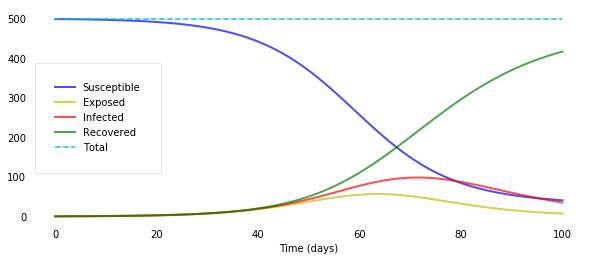

In [6]:
plotseird(t, S, E, I, R)

In [8]:
# get the real data
# fit the curve
data = pd.read_csv('SEIR_data.csv')
data.head()

,Date,S,E,I,R,Incidence
0,13/03/2020,528,0,0,0,0
1,14/03/2020,527,1,0,0,0
2,15/03/2020,527,1,0,0,0
3,16/03/2020,527,1,0,0,0
4,17/03/2020,527,1,0,0,0


In [9]:
def fit_odeint(x, beta, gamma,delta):
    return odeint(deriv, y0, x, args=(N, beta, gamma, delta))[:,2]

In [10]:
x = [i for i in range(0,data.shape[0])]
y = data['I']
dataz = zip(x,y)
# Do the sampling 100 times to get the error estimates 

popt, pcov = optimize.curve_fit(fit_odeint, x, y)
fitted = fit_odeint(x, *popt)
print(*popt)
perr = np.sqrt(np.diag(pcov))
print(pcov)
print(perr)
#print(type(popt))
print("R0 value : %2.4f" %(popt[0]/popt[1]) )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


8.55686505159 2.95899586883 0.280502068839
[[ 67.3179911    3.36668111  -2.41971636]
 [  3.36668111   0.25805619  -0.11092367]
 [ -2.41971636  -0.11092367   0.08838893]]
[ 8.20475418  0.50799232  0.29730275]
R0 value : 2.8918


[ 0.         -0.00633071 -0.00696964 -0.00711804 -0.00722541 -0.00733061
 -0.00743701 -0.00754492 -0.0076544  -0.00776547 -0.00787814 -0.00799246
 -0.00810843 -0.00822608 -0.00834545 -0.00846654 -0.00858939 -0.00871402
 -0.00884047 -0.00896874 -0.00909888 -0.0092309  -0.00936484 -0.00950073
 -0.00963858 -0.00977843 -0.00992032 -0.01006426 -0.01021029 -0.01035844
 -0.01050875 -0.01066123 -0.01081591 -0.01097285 -0.01113206 -0.01129359
 -0.01145746 -0.0116237  -0.01179236 -0.01196346 -0.01213704 -0.01231315
 -0.01249181 -0.01267306 -0.01285694 -0.01304348 -0.01323274 -0.01342475
 -0.01361954 -0.01381714 -0.01401762 -0.014221   -0.01442735 -0.01463668
 -0.01484905 -0.0150645  -0.01528307 -0.01550481 -0.01572978 -0.01595801
 -0.01618955]
[  0.00000000e+00   3.42732973e-01   1.37542240e+00   5.18743822e+00
   1.59061746e+01   3.00815112e+01   3.15560966e+01   2.30457442e+01
   1.45569059e+01   8.72733844e+00   5.12719164e+00   2.98530785e+00
   1.73060435e+00   1.00094948e+00   5.78208923e-

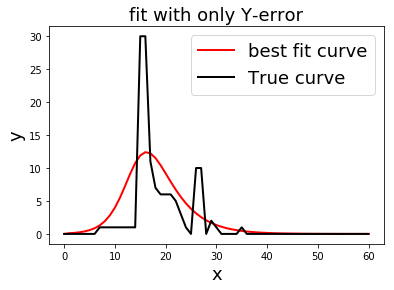

In [11]:
#print(fitted)
#plt.plot(x, y, '-')
#plt.plot(x, fitted, '-')
#plt.show()

# prepare confidence level curves
nstd = 1.0 # to draw 5-sigma intervals
popt_up = popt + nstd*perr
#popt_dw = popt – nstd*perr
popt_dw= popt-nstd*perr
fit = fit_odeint(x, *popt)
fit_up = fit_odeint(x, *popt_up)
fit_dw = fit_odeint(x, *popt_dw)
print(fit_dw)
print(fit_up)
#plot
fig, ax = plt.subplots(1)
#rcParams['xtick.labelsize'] = 18
#rcParams['ytick.labelsize'] = 18
#rcParams['font.size']= 20
#errorbar(x, y0, yerr=noise, xerr=0, hold=True, ecolor=’k’, fmt=’none’, label=’data’)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_title('fit with only Y-error' , fontsize=18)
plt.plot(x, fit, 'r', lw=2, label='best fit curve')
plt.plot(x, y, 'k-', lw=2, label='True curve')
#plt.plot(x,y,'k-', lw=2)
#ax.fill_between(x,fit_up, fit_dw, alpha = 0.25)
#ax.fill_between(x, fit_up, fit_dw, alpha=.25, label='5-sigma interval')

ax.legend(loc='upper right',fontsize=18)
plt.show()

## Programming the Dead-Compartment

In [12]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [13]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [14]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

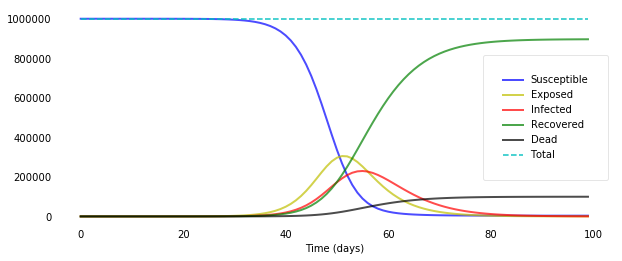

In [15]:
plotseird(t, S, E, I, R, D)

## Time-Dependent $R_{0}$

### Simple Approach: Single Lockdown

In [16]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [17]:
L = 40

In [18]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
def R_0(t):
    return 5.0 if t < L else 0.9
def beta(t):
    return R_0(t) * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [19]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

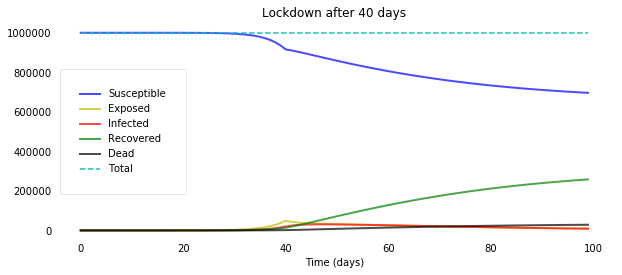

In [20]:
plotseird(t, S, E, I, R, D, L)

### Advanced Approach: logistic $R_{0}$

In [21]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [22]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [23]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values

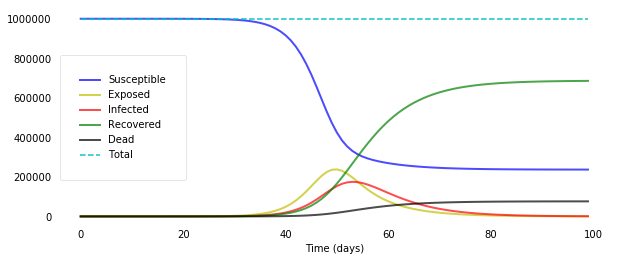

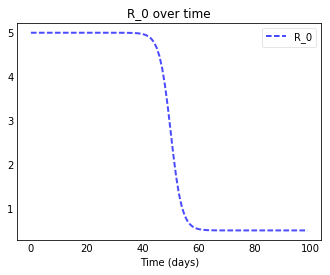

In [24]:
plotseird(t, S, E, I, R, D, R0=R0_over_time)

### Resource- and Age-Dependent Fatality Rate

In [25]:
def deriv(y, t, N, beta, gamma, delta, alpha_opt, rho):
    S, E, I, R, D = y
    def alpha(t):
        return s * I/N + alpha_opt

    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
    dRdt = (1 - alpha(t)) * gamma * I
    dDdt = alpha(t) * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [26]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
proportion_of_agegroup = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}
s = 0.01
alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [27]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha_opt, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
Alpha_over_time = [s * I[i]/N + alpha_opt for i in range(len(t))]  # to plot alpha over time

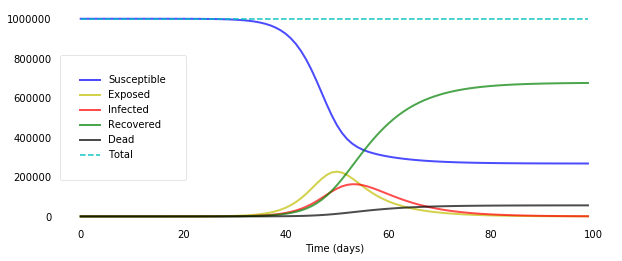

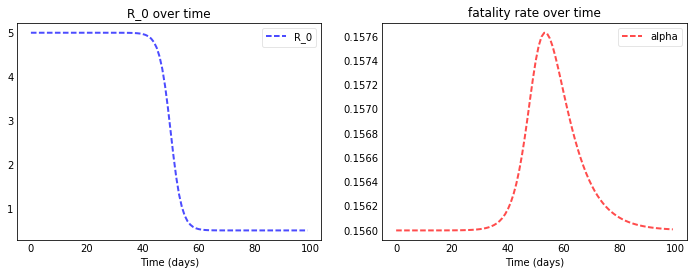

In [28]:
plotseird(t, S, E, I, R, D, R0=R0_over_time, Alpha=Alpha_over_time)